In [1]:
# Install required packages
!pip install opendatasets torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:


import opendatasets as od
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import joblib

In [4]:


# Download dataset
dataset_url = "https://www.kaggle.com/datasets/msambare/fer2013"
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ishab123
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [00:00<00:00, 140MB/s] 


In [5]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


In [6]:

# Set up data directories
base_dir = '/content/fer2013'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


In [7]:

# Enhanced data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.1)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [52]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torchvision.utils import make_grid


In [53]:
# Function to display a tensor image
def show_image(img, title=None):
    # Convert tensor to numpy array
    if isinstance(img, torch.Tensor):
        # If it's a tensor with normalization, denormalize it
        if img.min() < 0:
            img = img * 0.5 + 0.5  # Denormalize
        img = img.numpy().transpose((1, 2, 0))
        # Clip values to be between 0 and 1
        img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')


In [54]:
# Load a sample image from the test dataset
def get_sample_image():
    # You can replace this with code to get an actual image from your dataset
    # For demonstration purposes, let's just get the first image from the test loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    sample_image = images[0]
    true_label = labels[0].item()

    # Convert tensor back to PIL for transformations
    # First denormalize
    denorm = transforms.Normalize([-1, -1, -1], [2, 2, 2])
    sample_image = denorm(sample_image)
    sample_image_pil = transforms.ToPILImage()(sample_image)

    return sample_image_pil, class_names[true_label]


In [55]:
# Define individual transformations for visualization
transformations = [
    ('Original', None),
    ('Resize (224x224)', transforms.Resize((224, 224))),
    ('Random Horizontal Flip', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0)  # p=1.0 to ensure it flips
    ])),
    ('Random Rotation (15°)', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15)
    ])),
    ('Random Affine (Translation)', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ])),
    ('Color Jitter', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ])),
    ('Random Perspective', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0)  # p=1.0 to ensure it applies
    ])),
    ('Normalize', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])),
    ('Random Erasing', transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.RandomErasing(p=1.0)  # p=1.0 to ensure it applies
    ])),
    ('Full Pipeline (Sample 1)', transform_train),
    ('Full Pipeline (Sample 2)', transform_train),
    ('Full Pipeline (Sample 3)', transform_train),
    ('Test Transform', transform_test)
]


In [56]:
# Get a sample image
sample_image, true_label = get_sample_image()


In [57]:
# Create a figure to display all transformations
plt.figure(figsize=(20, 15))
num_transforms = len(transformations)
rows = (num_transforms + 3) // 4  # Ceiling division for number of rows
cols = min(4, num_transforms)  # Maximum 4 columns

<Figure size 2000x1500 with 0 Axes>

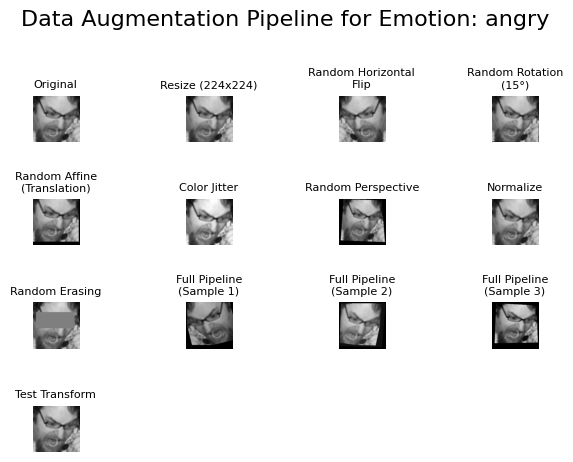

In [58]:
# # Apply each transformation and display the result
# for idx, (title, transform) in enumerate(transformations):
#     plt.subplot(rows, cols, idx +1)

#     if transform is None:
#         # Original image
#         img_to_show = sample_image
#         show_image(np.array(img_to_show) / 255.0, title)  # Convert PIL to numpy and normalize
#     else:
#         # Apply transformation
#         try:
#             transformed_img = transform(sample_image)
#             show_image(transformed_img, title)
#         except Exception as e:
#             plt.text(0.4, 0.4, f"Error: {str(e)}",
#                     horizontalalignment='center', verticalalignment='center')
#             plt.title(title)
# plt.suptitle(f"Data Augmentation Pipeline for Emotion: {true_label}", fontsize=16)
# plt.tight_layout()
# plt.subplots_adjust(top=0.80)  # Adjust for the suptitle
# plt.show()
import textwrap

# Apply each transformation and display the result
for idx, (title, transform) in enumerate(transformations):
    plt.subplot(rows, cols, idx + 1)

    # Wrap the title text if it's too long
    wrapped_title = textwrap.fill(title, width=20)  # Adjust width for wrapping

    if transform is None:
        # Original image
        img_to_show = sample_image
        show_image(np.array(img_to_show) / 255.0, wrapped_title)  # Convert PIL to numpy and normalize
    else:
        # Apply transformation
        try:
            transformed_img = transform(sample_image)
            show_image(transformed_img, wrapped_title)
        except Exception as e:
            # In case of an error, place error message
            plt.text(0.5, 0.5, f"Error: {str(e)}",
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes, fontsize=12, color='red')
            wrapped_title = "Error"

    plt.title(wrapped_title, fontsize=8)  # Set font size smaller for long titles

plt.suptitle(f"Data Augmentation Pipeline for Emotion: {true_label}", fontsize=16)
plt.tight_layout(pad=2.0)  # Increase padding to avoid overlap
plt.subplots_adjust(top=0.80)  # Adjust for the suptitle
plt.show()





In [59]:
# Save the figure for sharing
plt.savefig('data_augmentation_visualization.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'data_augmentation_visualization.png'")

Visualization saved as 'data_augmentation_visualization.png'


<Figure size 640x480 with 0 Axes>

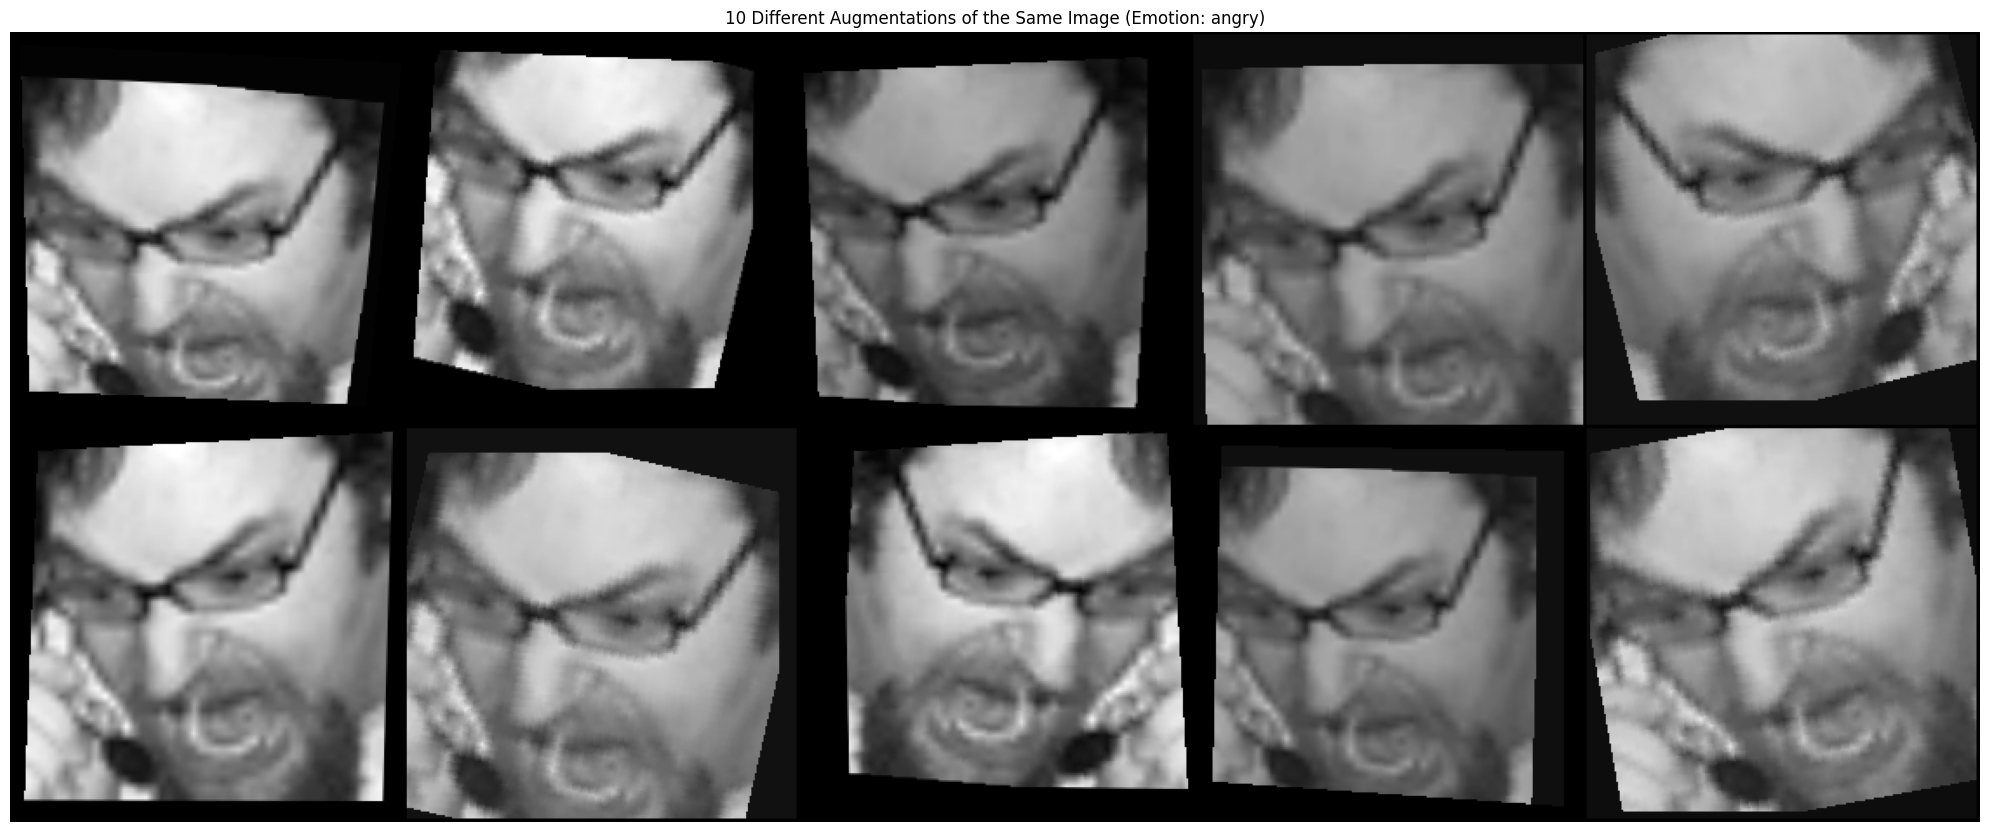

Multiple augmentations visualization saved as 'multiple_augmentations.png'


<Figure size 640x480 with 0 Axes>

In [60]:
# For a more detailed view, let's also create a grid showing multiple variations of the full pipeline
def show_multiple_augmentations(img, transform, n=10, title="Multiple Augmentations"):
    plt.figure(figsize=(20, 10))

    # Apply the transformation multiple times
    images = [transform(img) for _ in range(n)]

    # Convert to a grid
    grid = make_grid(images, nrow=5, normalize=True)

    # Display the grid
    show_image(grid.permute(1, 2, 0).numpy(), title)
    plt.tight_layout()
    plt.show()

    # Save this visualization too
    plt.savefig('multiple_augmentations.png', dpi=300, bbox_inches='tight')
    print("Multiple augmentations visualization saved as 'multiple_augmentations.png'")

# Show 10 different augmentations with the full pipeline
show_multiple_augmentations(sample_image, transform_train, n=10,
                           title=f"10 Different Augmentations of the Same Image (Emotion: {true_label})")

In [8]:

# Load and split datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [9]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [10]:
# Modified ResNet50 with dropout
class EmotionResNet(nn.Module):
    def __init__(self, num_classes):
        super(EmotionResNet, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Modify the final layers
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Add dropout to some intermediate layers
        self.resnet.layer3.add_module('dropout', nn.Dropout(0.2))
        self.resnet.layer4.add_module('dropout', nn.Dropout(0.2))

    def forward(self, x):
        return self.resnet(x)

In [11]:
# # Initialize model
num_classes = len(train_dataset.dataset.classes)
model = EmotionResNet(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


In [12]:

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [13]:

# Optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


In [14]:

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

# Training and validation function
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    early_stopping = EarlyStopping(patience=3)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Update learning rate
        scheduler.step(val_accuracy)

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    #     # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)

            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved as best_model.pth")

            model_state_dict = model.state_dict()


            # Save the state_dict using joblib
            joblib.dump(model_state_dict, 'best_model.joblib')
            print("Model state_dict saved as best_model.joblib")
            break


    return train_losses, train_accuracies, val_losses, val_accuracies


# Train the model
num_epochs = 100
metrics = train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
train_losses, train_accuracies, val_losses, val_accuracies = metrics



Epoch [1/100]
Training - Loss: 1.8323, Accuracy: 25.29%
Validation - Loss: 1.8365, Accuracy: 25.08%
--------------------------------------------------
Epoch [2/100]
Training - Loss: 1.8050, Accuracy: 26.91%
Validation - Loss: 1.7815, Accuracy: 29.36%
--------------------------------------------------
Epoch [3/100]
Training - Loss: 1.7489, Accuracy: 31.00%
Validation - Loss: 1.7698, Accuracy: 30.06%
--------------------------------------------------
Epoch [4/100]
Training - Loss: 1.6751, Accuracy: 36.03%
Validation - Loss: 1.6515, Accuracy: 37.70%
--------------------------------------------------
Epoch [5/100]
Training - Loss: 1.6231, Accuracy: 39.27%
Validation - Loss: 1.6008, Accuracy: 40.44%
--------------------------------------------------
Epoch [6/100]
Training - Loss: 1.5826, Accuracy: 41.76%
Validation - Loss: 1.5637, Accuracy: 43.05%
--------------------------------------------------
Epoch [7/100]
Training - Loss: 1.5418, Accuracy: 44.32%
Validation - Loss: 1.5376, Accuracy: 4

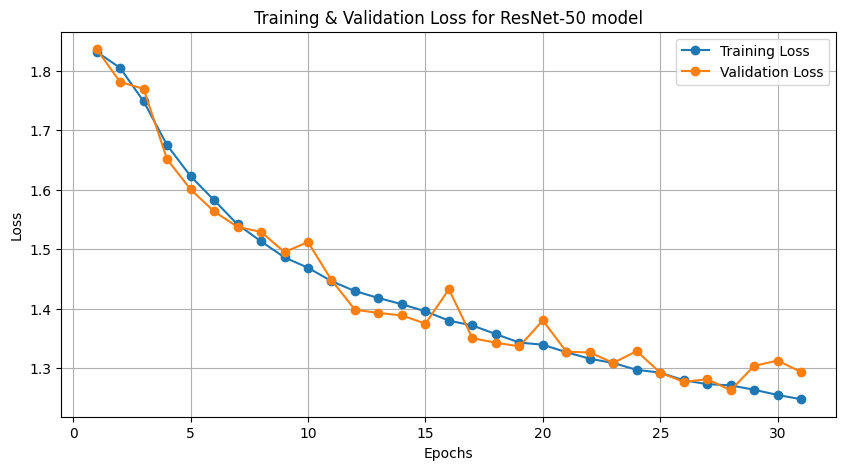

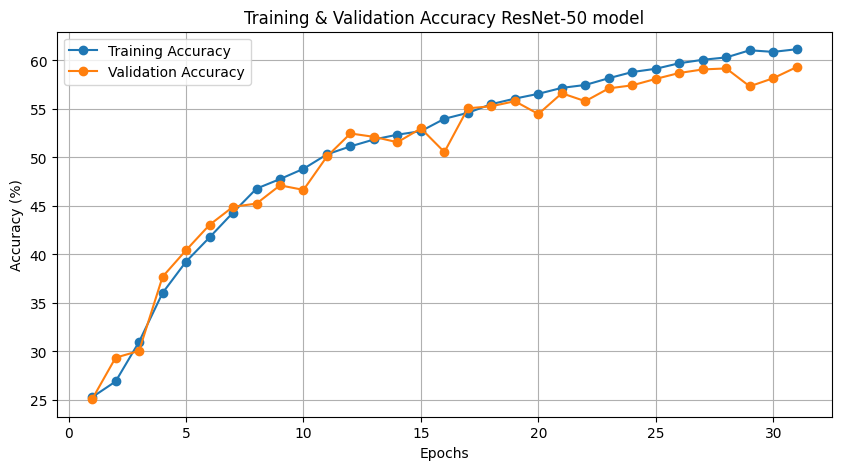

In [19]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss for ResNet-50 model")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy ResNet-50 model")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from google.colab import files
files.download("/content/best_model.pth")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

In [22]:
# Function to evaluate the model and compute metrics
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Lists to store true labels and predictions
    all_predictions = []
    all_labels = []

    # No gradient computation needed for evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Compute precision, recall, and F1 score
    precision = precision_score(all_labels, all_predictions, average=None)
    recall = recall_score(all_labels, all_predictions, average=None)
    f1 = f1_score(all_labels, all_predictions, average=None)

    # Compute macro-averaged metrics
    macro_precision = precision_score(all_labels, all_predictions, average='macro')
    macro_recall = recall_score(all_labels, all_predictions, average='macro')
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')

    # Get class names if available
    try:
        if hasattr(test_loader.dataset, 'dataset'):
            class_names = test_loader.dataset.dataset.classes
        else:
            class_names = test_loader.dataset.classes
    except:
        # If class names cannot be accessed, use numeric labels
        class_names = [f"Class {i}" for i in range(len(precision))]

    # Get classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    return {
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'report': report,
        'class_names': class_names,
        'predictions': all_predictions,
        'labels': all_labels
    }


In [23]:
# Function to visualize the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [24]:
# Function to plot metrics per class
def plot_class_metrics(precision, recall, f1, class_names):
    plt.figure(figsize=(12, 6))

    x = np.arange(len(class_names))
    width = 0.25

    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')

    plt.xlabel('Emotion Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-score by Class')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [25]:
# Get the actual class names from the test dataset directly
try:
    class_names = test_dataset.classes
    print(f"Detected class names: {class_names}")
except:
    # If class names cannot be accessed, use numeric labels based on number of classes in the model
    class_names = [f"Class {i}" for i in range(num_classes)]
    print(f"Using default class names: {class_names}")

Detected class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [26]:
# Load the best model (handle the warning by adding weights_only=True)
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model = model.to(device)

In [27]:
# Evaluate the model
metrics = evaluate_model(model, test_loader, device)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [28]:
# Print overall metrics
print("Classification Report:")
print(metrics['report'])

print("\nMacro-averaged Metrics:")
print(f"Precision: {metrics['macro_precision']:.4f}")
print(f"Recall: {metrics['macro_recall']:.4f}")
print(f"F1-score: {metrics['macro_f1']:.4f}")

Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.46      0.51       958
     disgust       0.00      0.00      0.00       111
        fear       0.46      0.22      0.30      1024
       happy       0.78      0.90      0.83      1774
     neutral       0.55      0.64      0.59      1233
         sad       0.48      0.53      0.50      1247
    surprise       0.66      0.81      0.73       831

    accuracy                           0.61      7178
   macro avg       0.50      0.51      0.50      7178
weighted avg       0.59      0.61      0.59      7178


Macro-averaged Metrics:
Precision: 0.4988
Recall: 0.5102
F1-score: 0.4953


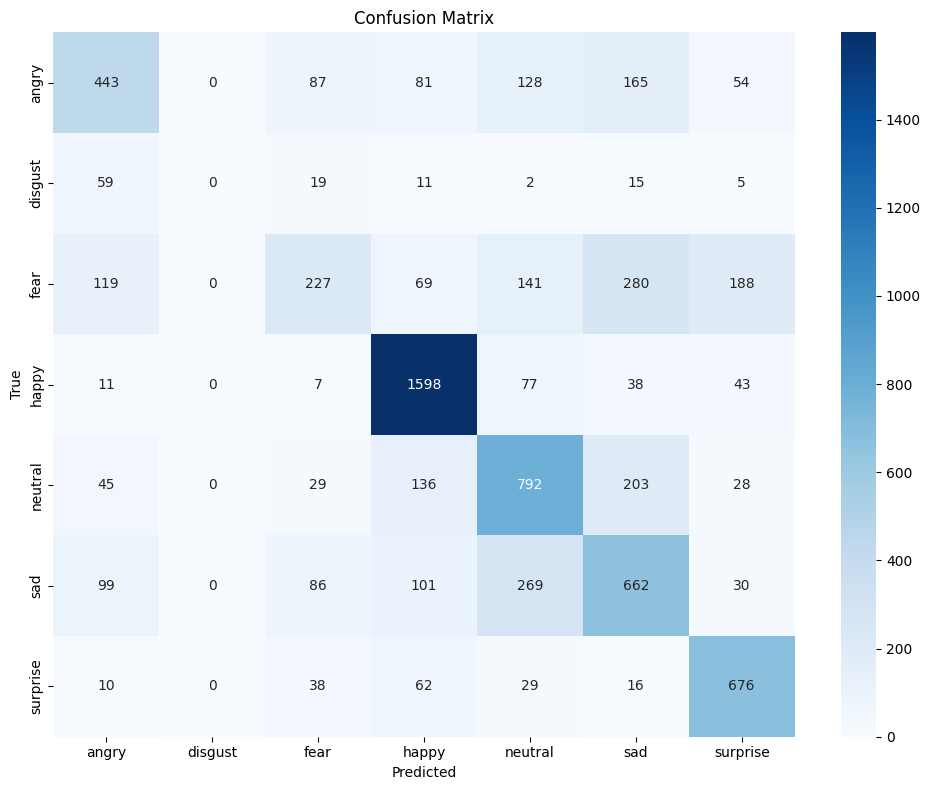

In [29]:
# Plot confusion matrix
plot_confusion_matrix(metrics['confusion_matrix'], metrics['class_names'])

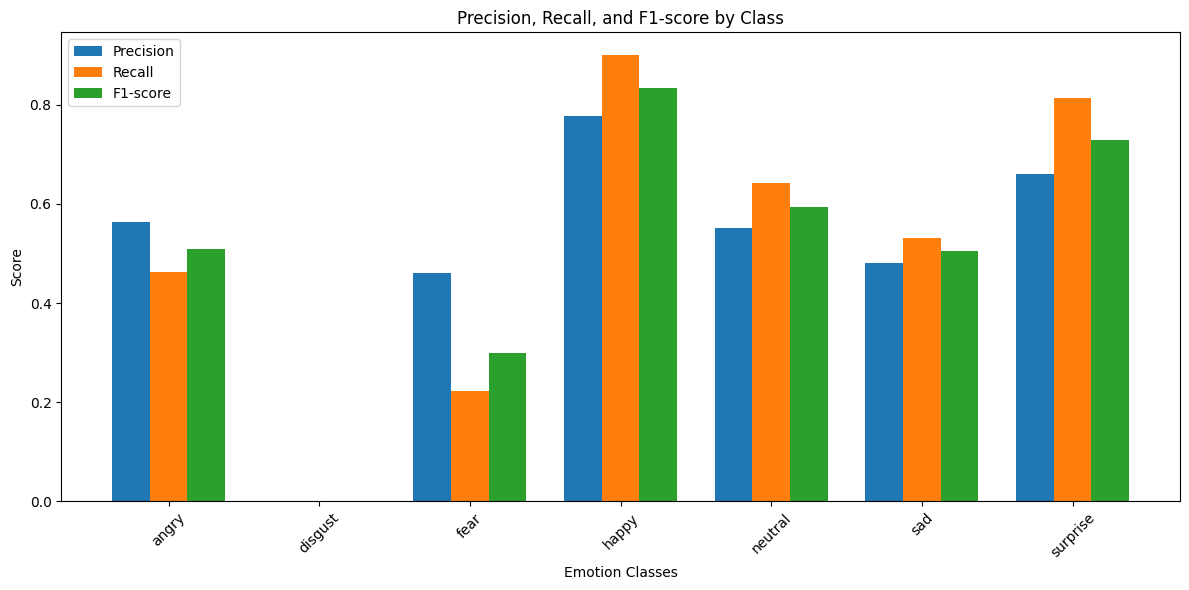

In [30]:
# Plot per-class metrics
plot_class_metrics(metrics['precision'], metrics['recall'], metrics['f1'], metrics['class_names'])

In [31]:
# Create a more detailed visualization showing incorrectly classified examples
def visualize_misclassifications(model, test_loader, device, class_names, num_examples=5):
    model.eval()
    misclassified_examples = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            # Find misclassified examples
            for i, (prediction, label) in enumerate(zip(predictions, labels)):
                if prediction != label:
                    misclassified_examples.append({
                        'image': images[i].cpu(),
                        'true': label.item(),
                        'predicted': prediction.item()
                    })

                    if len(misclassified_examples) >= num_examples:
                        break

            if len(misclassified_examples) >= num_examples:
                break

    if misclassified_examples:
        # Denormalize images for display
        denorm = transforms.Normalize([-1, -1, -1], [2, 2, 2])

        # Plot misclassified examples
        fig, axes = plt.subplots(1, min(num_examples, len(misclassified_examples)), figsize=(15, 3))
        if num_examples == 1:
            axes = [axes]

        for i, example in enumerate(misclassified_examples[:num_examples]):
            img = denorm(example['image']).permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(np.clip(img, 0, 1))
            true_class = class_names[example['true']] if example['true'] < len(class_names) else f"Class {example['true']}"
            pred_class = class_names[example['predicted']] if example['predicted'] < len(class_names) else f"Class {example['predicted']}"
            axes[i].set_title(f"True: {true_class}\nPred: {pred_class}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified examples found in the current batch.")

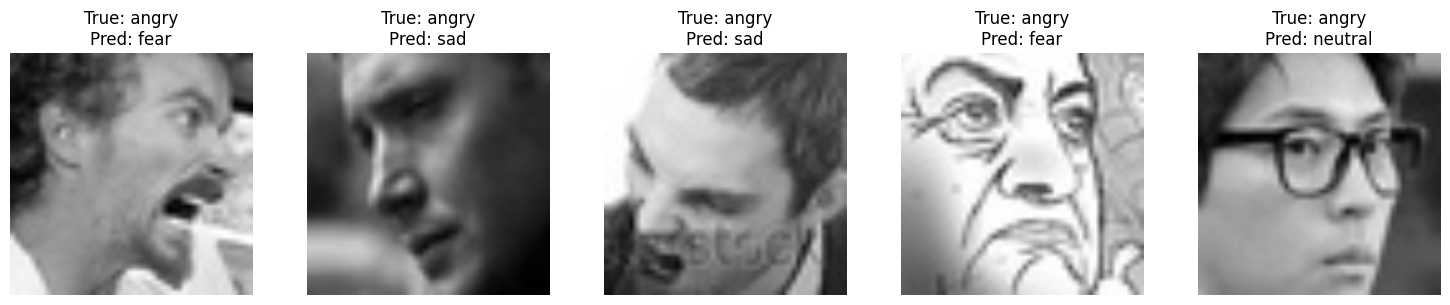

In [32]:
# Visualize some misclassified examples
visualize_misclassifications(model, test_loader, device, metrics['class_names'])

In [33]:
from google.colab import files
files.download('best_model.pth')
files.download('best_model.joblib')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# First, let's create a wrapper class for the model that includes preprocessing
class EmotionClassifier:
    def __init__(self, model, transform, class_names, device='cpu'):
        self.model = model
        self.transform = transform
        self.class_names = class_names
        self.device = device

        # Move model to the specified device and set to evaluation mode
        self.model.to(self.device)
        self.model.eval()

    def preprocess_image(self, image):
        """
        Preprocess a PIL Image or numpy array for the model
        """
        if isinstance(image, np.ndarray):
            # Convert numpy array to PIL Image
            image = Image.fromarray(image.astype('uint8'))

        # Apply transformations
        tensor = self.transform(image).unsqueeze(0)  # Add batch dimension
        return tensor.to(self.device)

    def predict(self, image):
        """
        Predict the emotion of the input image

        Args:
            image: PIL Image or numpy array

        Returns:
            Dictionary with prediction results
        """
        # Preprocess the image
        tensor = self.preprocess_image(image)

        # Run inference
        with torch.no_grad():
            outputs = self.model(tensor)

            # Get predicted class
            _, predicted_idx = torch.max(outputs, 1)
            predicted_idx = predicted_idx.item()

            # Get probabilities using softmax
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]

            # Create results dictionary
            results = {
                'class_index': predicted_idx,
                'class_name': self.class_names[predicted_idx],
                'confidence': probabilities[predicted_idx].item(),
                'all_probabilities': {
                    self.class_names[i]: prob.item()
                    for i, prob in enumerate(probabilities)
                }
            }

            return results

In [35]:
# Transform for inference (must match the test transform)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [36]:
# Get class names
class_names = test_dataset.classes

In [37]:
# Set the device
device = torch.device("cpu")  # Use CPU for deployment


In [38]:
# Load the trained model
model.load_state_dict(torch.load("best_model.pth", weights_only=True, map_location=device))
model.to(device)
model.eval()

EmotionResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [39]:
# Create the classifier wrapper
emotion_classifier = EmotionClassifier(model, inference_transform, class_names, device)

In [40]:
# Create a deployment directory
os.makedirs("emotion_model_deployment", exist_ok=True)

In [41]:
# Save the class names and model architecture details
joblib.dump(class_names, "emotion_model_deployment/class_names.joblib")

['emotion_model_deployment/class_names.joblib']

In [42]:
# Save the full PyTorch model
torch.save(model, "emotion_model_deployment/full_model.pth")

In [43]:
# Also save the state dict for flexibility
torch.save(model.state_dict(), "emotion_model_deployment/model_state_dict.pth")

In [44]:
# Save the transform parameters
transform_config = {
    "resize_size": (224, 224),
    "normalization_mean": [0.5, 0.5, 0.5],
    "normalization_std": [0.5, 0.5, 0.5]
}
joblib.dump(transform_config, "emotion_model_deployment/transform_config.joblib")

['emotion_model_deployment/transform_config.joblib']

In [45]:
# Save the entire classifier (note: this may not work perfectly when loading on different environments)
joblib.dump(emotion_classifier, "emotion_model_deployment/emotion_classifier.joblib")

['emotion_model_deployment/emotion_classifier.joblib']

In [46]:
# Create a README file with usage instructions
with open("emotion_model_deployment/README.md", "w") as f:
    f.write("""# Emotion Recognition Model

This directory contains the trained emotion recognition model and utilities.

## Contents
- `full_model.pth`: Complete PyTorch model
- `model_state_dict.pth`: Model state dictionary only
- `class_names.joblib`: List of emotion class names
- `transform_config.joblib`: Configuration for image preprocessing
- `emotion_classifier.joblib`: Complete classifier with preprocessing (may need environment compatibility)

## Usage Example

```python
import torch
import joblib
from PIL import Image
import torchvision.transforms as transforms
from model_architecture import EmotionResNet18  # Import your model architecture

# Load class names and transform config
class_names = joblib.load("class_names.joblib")
transform_config = joblib.load("transform_config.joblib")

# Create transform
inference_transform = transforms.Compose([
    transforms.Resize(transform_config["resize_size"]),
    transforms.ToTensor(),
    transforms.Normalize(
        transform_config["normalization_mean"],
        transform_config["normalization_std"]
    )
])

# Load model (Option 1 - full model)
model = torch.load("full_model.pth")

# OR Load model (Option 2 - architecture + state dict)
# num_classes = len(class_names)
# model = EmotionResNet18(num_classes)
# model.load_state_dict(torch.load("model_state_dict.pth"))

model.eval()

# Prepare image
image = Image.open("example_image.jpg")
tensor = inference_transform(image).unsqueeze(0)

# Get prediction
with torch.no_grad():
    outputs = model(tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"Predicted emotion: {predicted_class}")
```
""")

In [47]:
# Create a simple demo script
with open("emotion_model_deployment/demo.py", "w") as f:
    f.write("""import torch
import joblib
from PIL import Image
import torchvision.transforms as transforms
import argparse
import matplotlib.pyplot as plt
import numpy as np

# Define the EmotionResNet18 architecture
import torch.nn as nn
from torchvision import models

class EmotionResNet18(nn.Module):
    def __init__(self, num_classes):
        super(EmotionResNet18, self).__init__()
        self.resnet = models.resnet18(weights=None)

        # Modify the final layers
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Add dropout to some intermediate layers
        self.resnet.layer3.add_module('dropout', nn.Dropout(0.2))
        self.resnet.layer4.add_module('dropout', nn.Dropout(0.2))

    def forward(self, x):
        return self.resnet(x)

def predict_emotion(image_path):
    # Load class names and transform config
    class_names = joblib.load("class_names.joblib")
    transform_config = joblib.load("transform_config.joblib")

    # Create transform
    inference_transform = transforms.Compose([
        transforms.Resize(transform_config["resize_size"]),
        transforms.ToTensor(),
        transforms.Normalize(
            transform_config["normalization_mean"],
            transform_config["normalization_std"]
        )
    ])

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Try loading the full model first
    try:
        model = torch.load("full_model.pth", map_location=device)
    except:
        # If that fails, load the architecture and state dict separately
        num_classes = len(class_names)
        model = EmotionResNet18(num_classes)
        model.load_state_dict(torch.load("model_state_dict.pth", map_location=device))

    model.to(device)
    model.eval()

    # Load and prepare image
    image = Image.open(image_path).convert('RGB')
    tensor = inference_transform(image).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        confidence, predicted = torch.max(probabilities, 0)
        predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(np.array(image))
    plt.title(f"Predicted emotion: {predicted_class} (Confidence: {confidence.item():.2f})")
    plt.axis('off')
    plt.show()

    # Print all probabilities
    print("Emotion probabilities:")
    for i, emotion in enumerate(class_names):
        print(f"{emotion}: {probabilities[i].item():.4f}")

    return predicted_class, confidence.item()

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Emotion Recognition Demo")
    parser.add_argument("image_path", help="Path to the image file")
    args = parser.parse_args()

    predict_emotion(args.image_path)
""")

In [48]:
# Create a deployment package (zip file)
import shutil

In [49]:
shutil.make_archive("emotion_recognition_model", "zip", "emotion_model_deployment")

print("Model deployment package created successfully!")
print("You can download the deployment package using the code below:")
print("from google.colab import files")
print("files.download('emotion_recognition_model.zip')")

# Test the deployed model with a sample image
print("\nTesting the model on a sample image:")

Model deployment package created successfully!
You can download the deployment package using the code below:
from google.colab import files
files.download('emotion_recognition_model.zip')

Testing the model on a sample image:


In [50]:
from google.colab import files
files.download('emotion_recognition_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

True emotion: angry
Predicted emotion: angry
Confidence: 0.4325


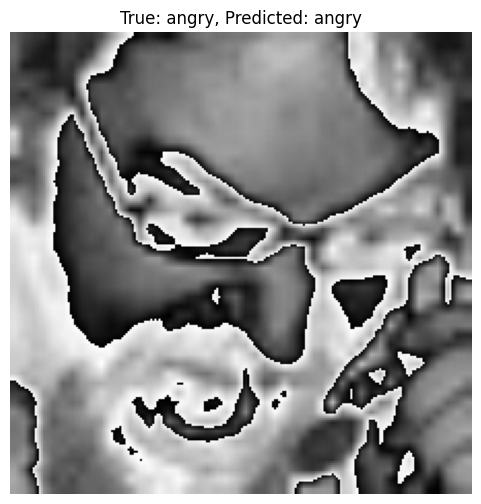


All probabilities:
angry: 0.4325
disgust: 0.0374
fear: 0.1134
happy: 0.2323
neutral: 0.0514
sad: 0.0810
surprise: 0.0520


In [51]:
# Let's grab a sample image from the test dataset
def test_deployed_model():
    # Get a sample image from the test dataset
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    sample_image = images[0]
    true_label = labels[0].item()

    # Convert tensor to PIL Image
    sample_image_pil = transforms.ToPILImage()(sample_image)

    # Save the image temporarily
    sample_image_pil.save("sample_image.jpg")

    # Use the wrapper to make a prediction
    prediction = emotion_classifier.predict(sample_image_pil)

    print(f"True emotion: {class_names[true_label]}")
    print(f"Predicted emotion: {prediction['class_name']}")
    print(f"Confidence: {prediction['confidence']:.4f}")

    # Display the image with the prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(sample_image_pil))
    plt.title(f"True: {class_names[true_label]}, Predicted: {prediction['class_name']}")
    plt.axis('off')
    plt.show()

    # Show all probabilities
    print("\nAll probabilities:")
    for emotion, prob in prediction['all_probabilities'].items():
        print(f"{emotion}: {prob:.4f}")

# Run the test
test_deployed_model()